In [1]:
import pandas as pd
import datetime as dt
from IPython.display import display, Image # Displays things nicely
import matplotlib.pyplot as plt # Helps plot
# helper function to print info about dataframe

def df_info(df):
    print("Shape: ", df.shape)
    print("dtypes: ", df.dtypes.to_dict())
    print("index dtype: ", df.index.dtype)
    return pd.concat([df.head(3), df.tail(3)])

IRI dataset is a scanner level data set encompasing about 12 years, 93 markets in the United States. Scanner means the level of observation is at the upc-barcode scanner level. 

There are several layers to the dataset:
- Within each year. Within each year there are files broken down by type of product. For example, beer, salty snacks, etc.
- Then within that there is break down of type of store (grocer vs drug store) and some suplementary datasets for the panel dimension. This is the "scanner" dataset. 
- Then there is this external folder with product descriptions. These provide UPC codes, some description of the product, e.g. "Bud Light, Long Neck Bottles, 6 pack, total fluid ounces" and information about the producer, vendor (in this case Anheuser Busch). 
- Finally there is a store level dataset, "Delivery Stores" (not sure why this is called that). This allows you to match the store level information with the scanner data set.

**Note these are very big files: The 2007 Beer is About 560mb.**

One issue is that the format is not clear. Its a fixed with format. Pandas should be able to handle it, the concern is that we may need to specify the width, it appears not as the output looks like that in the documentation. So it should have 11 columns. Another way to "look at the data" is to open it in Atom (Atom was able to open it with no problem).

Here is what I want to do, I want to look at a well defined product and its variation across space.

### Read in the Scanner Dataset

In [2]:
file_path = "F://Academic Dataset External//"
year = "Year7" 
beer_file = "//External//beer//beer_groc_1427_1478"
file = file_path + year + beer_file 

scan_beer = pd.read_fwf(file)

In [3]:
display(scan_beer.head(10))
display(scan_beer.shape)

,IRI_KEY,WEEK,SY,GE,VEND,ITEM,UNITS,DOLLARS,F,D,PR
0,234212,1427,0,1,72783,200,2,17.98,NONE,0,0
1,234212,1427,0,1,18200,10985,1,6.49,NONE,0,0
2,234212,1427,0,1,18200,11981,2,12.98,NONE,0,0
3,234212,1427,0,1,18200,6992,1,6.99,NONE,0,0
4,234212,1427,0,1,18200,468,18,26.82,NONE,0,0
5,234212,1427,0,1,18200,53047,5,42.75,NONE,0,0
6,234212,1427,0,1,18200,53168,12,179.88,A,0,1
7,234212,1427,0,1,18200,769,29,246.51,NONE,1,1
8,234212,1427,0,1,18200,53349,1,16.49,NONE,0,0
9,234212,1427,0,1,18200,833,14,65.66,NONE,0,1


(10504073, 11)

So here the head looks good, like what it should when opened in Atom. 
- The IRI_KEY is a value that matches the sames with the store
- WEEK is the week of the transactions
- The 12 digit UPC code is SY,GE, VEND, ITEM, combined. The ITEM is the item part of the UPC, the VEND number is the vender number.
- Units and Dollars are listed. A "unit price" can then be constructed by dividing UNITS / DOLLARS
- Finlay there are some codes. These are to inform us if there were markiting promotions, etc. associated with the store,product, week.

In [4]:
top_venders = scan_beer.VEND.value_counts()
top_venders = pd.DataFrame(top_venders)

top_venders

display(top_venders.head(10))

,VEND
18200,2619458
34100,1552827
71990,824593
80660,533388
72890,423798
82000,395419
87692,305057
35985,278439
83820,266493
72311,179851


### Match up (or focus on specific products)

Now lets find out who these guys are. To do so, I'm going to bring in the product attributes file, then merge top venders with the names

In [33]:
file = "F://Academic Dataset External//parsed stub files 2007//prod_beer.xlsx"

prod_beer = pd.read_excel(file)

display(prod_beer.head())

,L1,L2,L3,L4,L5,L9,Level,UPC,SY,GE,...,ITEM,*STUBSPEC 1416IS 00004,VOL_EQ,PRODUCT TYPE,TYPE OF BEER/ALE,PACKAGE,FLAVOR/SCENT,SIZE,CALORIE LEVEL,COLOR
0,CATEGORY - BEER/ALE/ALCOHOLIC CID,DOMESTIC BEER/ALE (INC NON-ALCOH,ABC WINE & SPIRITS,ABC WINE & SPIRITS,ABC ALE,+ABCAL ALE BEER CAN 12OZ,9,00-01-85674-60002,0,1,...,60002,+ABCAL ALE BEER CAN 12OZ 0 1 8...,0.0417,BEER,ALE,CAN,MISSING,MISSING,MISSING,MISSING
1,CATEGORY - BEER/ALE/ALCOHOLIC CID,DOMESTIC BEER/ALE (INC NON-ALCOH,ABC WINE & SPIRITS,ABC WINE & SPIRITS,ABC ALE,+ABCAL ALE BEER CAN 72OZ,9,00-01-85674-60001,0,1,...,60001,+ABCAL ALE BEER CAN 72OZ 0 1 8...,0.2500,BEER,ALE,CAN,MISSING,MISSING,MISSING,MISSING
2,CATEGORY - BEER/ALE/ALCOHOLIC CID,DOMESTIC BEER/ALE (INC NON-ALCOH,ABITA BREWING CO INC,ABITA BREWING CO INC,ABITA AMBER,+ABTAM LAGER BEER GB 12OZ,9,27-01-15502-01124,27,1,...,1124,+ABTAM LAGER BEER GB 12OZ27 1 1...,0.0417,BEER,LAGER,GLASS BOTTLE,MISSING,MISSING,MISSING,AMBER
3,CATEGORY - BEER/ALE/ALCOHOLIC CID,DOMESTIC BEER/ALE (INC NON-ALCOH,ABITA BREWING CO INC,ABITA BREWING CO INC,ABITA AMBER,+ABTAM LAGER BEER GB 12OZ,9,00-01-80020-00001,0,1,...,1,+ABTAM LAGER BEER GB 12OZ 0 1 8...,0.0417,BEER,LAGER,GLASS BOTTLE,MISSING,MISSING,MISSING,AMBER
4,CATEGORY - BEER/ALE/ALCOHOLIC CID,DOMESTIC BEER/ALE (INC NON-ALCOH,ABITA BREWING CO INC,ABITA BREWING CO INC,ABITA AMBER,+ABTAM LAGER BEER GBCRT 72OZ,9,00-01-80020-24221,0,1,...,24221,+ABTAM LAGER BEER GBCRT 72OZ 0 1 8...,0.2500,BEER,LAGER,GLASS BOTTLE IN CRTN,MISSING,MISSING,MISSING,AMBER


In [34]:
#display(prod_beer.columns)

display(pd.DataFrame(prod_beer[prod_beer.VEND == 18200].L3.value_counts()))

display(pd.DataFrame(prod_beer[prod_beer.VEND == 34100].L3.value_counts()))

display(pd.DataFrame(prod_beer[prod_beer.VEND == 71990].L3.value_counts()))

display(pd.DataFrame(prod_beer[prod_beer.VEND == 80660].L5.value_counts()))

,L3
ANHEUSER-BUSCH INC,1098
CARLSBERG USA INC,3
REDHOOK ALE BREWERY,1


,L3
SABMILLER,628
ANHEUSER-BUSCH INC,7


,L3
MOLSON COORS BREWING COMPANY,218


,L5
CORONA EXTRA,17
MODELO ESPECIAL,13
SAINT PAULI GIRL,11
CORONA LIGHT,9
PACIFICO CLARA,8
NEGRA MODELO,5
SAINT PAULI GIRL DARK,5
CORONITA EXTRA,4
SAINT PAULI N A,3
TETLEYS ENGLISH ALE,3


There is some funny stuff going on, but it is small. 

**What this says:** Top companies are Anheuser-Busch, SABMILLER, MOLSON COORS, then 
CONSTELLATION BRANDS (which is Corona and Modello). The way to see the exact brands is to change it to `L5`.

Now I want to pull out some very specific products. Given the structure above in the scanner database, I want to pull out the UPC codes for BUDWEISER and BUDLIGHT, 6 pack bottles. How do I do this...boolean operations on our dataframe.

In [35]:
prod_beer[(prod_beer.L5 == "MILLER LITE")]

,L1,L2,L3,L4,L5,L9,Level,UPC,SY,GE,...,ITEM,*STUBSPEC 1416IS 00004,VOL_EQ,PRODUCT TYPE,TYPE OF BEER/ALE,PACKAGE,FLAVOR/SCENT,SIZE,CALORIE LEVEL,COLOR
6773,CATEGORY - BEER/ALE/ALCOHOLIC CID,DOMESTIC BEER/ALE (INC NON-ALCOH,SABMILLER,MILLER BREWING COMPANY,MILLER LITE,+MLRLT LAGER BEER CANCT 72OZ,9,03-01-41000-03546,3,1,...,3546,+MLRLT LAGER BEER CANCT 72OZ 3 1 4...,0.2500,BEER,LAGER,CAN IN CARTON,MISSING,MISSING,LIGHT,MISSING
6774,CATEGORY - BEER/ALE/ALCOHOLIC CID,DOMESTIC BEER/ALE (INC NON-ALCOH,SABMILLER,MILLER BREWING COMPANY,MILLER LITE,+MLRLT PLSNR BEER BAREL 992OZ,9,27-01-00001-61482,27,1,...,61482,+MLRLT PLSNR BEER BAREL 992OZ27 1 ...,3.4444,BEER,PILSNER,BARREL,MISSING,QUARTER,LIGHT,GLD
6775,CATEGORY - BEER/ALE/ALCOHOLIC CID,DOMESTIC BEER/ALE (INC NON-ALCOH,SABMILLER,MILLER BREWING COMPANY,MILLER LITE,+MLRLT PLSNR BEER CAN 10OZ,9,27-01-00007-07614,27,1,...,7614,+MLRLT PLSNR BEER CAN 10OZ27 1 ...,0.0347,BEER,PILSNER,CAN,MISSING,MISSING,LIGHT,MISSING
6776,CATEGORY - BEER/ALE/ALCOHOLIC CID,DOMESTIC BEER/ALE (INC NON-ALCOH,SABMILLER,MILLER BREWING COMPANY,MILLER LITE,+MLRLT PLSNR BEER CAN 12OZ,9,27-02-00001-06633,27,2,...,6633,+MLRLT PLSNR BEER CAN 12OZ27 2 ...,0.0417,BEER,PILSNER,CAN,REGULAR,MISSING,LIGHT,GLD
6777,CATEGORY - BEER/ALE/ALCOHOLIC CID,DOMESTIC BEER/ALE (INC NON-ALCOH,SABMILLER,MILLER BREWING COMPANY,MILLER LITE,+MLRLT PLSNR BEER CAN 12OZ,9,27-01-00007-06202,27,1,...,6202,+MLRLT PLSNR BEER CAN 12OZ27 1 ...,0.0417,BEER,PILSNER,CAN,MISSING,MISSING,LIGHT,MISSING
6778,CATEGORY - BEER/ALE/ALCOHOLIC CID,DOMESTIC BEER/ALE (INC NON-ALCOH,SABMILLER,MILLER BREWING COMPANY,MILLER LITE,+MLRLT PLSNR BEER CAN 12OZ,9,27-01-15504-02973,27,1,...,2973,+MLRLT PLSNR BEER CAN 12OZ27 1 1...,0.0417,BEER,PILSNER,CAN,MISSING,MISSING,LIGHT,MISSING
6779,CATEGORY - BEER/ALE/ALCOHOLIC CID,DOMESTIC BEER/ALE (INC NON-ALCOH,SABMILLER,MILLER BREWING COMPANY,MILLER LITE,+MLRLT PLSNR BEER CAN 12OZ,9,00-01-34100-57209,0,1,...,57209,+MLRLT PLSNR BEER CAN 12OZ 0 1 3...,0.0417,BEER,PILSNER,CAN,MISSING,MISSING,LITE,MISSING
6780,CATEGORY - BEER/ALE/ALCOHOLIC CID,DOMESTIC BEER/ALE (INC NON-ALCOH,SABMILLER,MILLER BREWING COMPANY,MILLER LITE,+MLRLT PLSNR BEER CAN 16OZ,9,27-01-00007-06203,27,1,...,6203,+MLRLT PLSNR BEER CAN 16OZ27 1 ...,0.0556,BEER,PILSNER,CAN,MISSING,MISSING,LIGHT,MISSING
6781,CATEGORY - BEER/ALE/ALCOHOLIC CID,DOMESTIC BEER/ALE (INC NON-ALCOH,SABMILLER,MILLER BREWING COMPANY,MILLER LITE,+MLRLT PLSNR BEER CAN 16OZ,9,27-01-15502-01298,27,1,...,1298,+MLRLT PLSNR BEER CAN 16OZ27 1 1...,0.0556,BEER,PILSNER,CAN,MISSING,MISSING,LIGHT,MISSING
6782,CATEGORY - BEER/ALE/ALCOHOLIC CID,DOMESTIC BEER/ALE (INC NON-ALCOH,SABMILLER,MILLER BREWING COMPANY,MILLER LITE,+MLRLT PLSNR BEER CAN 16OZ,9,27-01-15503-04052,27,1,...,4052,+MLRLT PLSNR BEER CAN 16OZ27 1 1...,0.0556,BEER,PILSNER,CAN,MISSING,MISSING,LIGHT,MISSING


In [181]:
millerlite_upcs = prod_beer[(prod_beer.L5 == "MILLER LITE") & (prod_beer.PACKAGE == "CAN")
         & (prod_beer.VOL_EQ == 0.50)].UPC

budlight_upcs = prod_beer[(prod_beer.L5 == "BUD LIGHT") & (prod_beer.PACKAGE == "LONG NECK BTL IN BOX")
         & (prod_beer.VOL_EQ == 0.50)].UPC

# Then I want to shape 

display(budlight_upcs.head())
display(millerlite_upcs.head()) # So I know this is messed up as the VEND number is wrong.

480    00-04-01820-00076
481    00-01-01820-00076
482    00-01-18200-00769
483    00-01-18200-00796
549    00-01-18200-08991
Name: UPC, dtype: object

6796    27-01-00001-60876
Name: UPC, dtype: object

So we have the UPC codes, now lets set them up so we can use them on the scanner dataset. The way I'm going to do this is to strip out the "-" and then create a dataframe.

In [182]:
print(budlight_upcs.str.split("-"))

480    [00, 04, 01820, 00076]
481    [00, 01, 01820, 00076]
482    [00, 01, 18200, 00769]
483    [00, 01, 18200, 00796]
549    [00, 01, 18200, 08991]
550    [01, 02, 82000, 07699]
551    [01, 01, 82000, 07699]
Name: UPC, dtype: object


In [183]:
budlight_upcs = pd.DataFrame(budlight_upcs.str.split("-").tolist())

In [184]:
var_list = ["SY", "GE", "VEND", "ITEM"]

budlight_upcs.columns = var_list

display(budlight_upcs.head())


,SY,GE,VEND,ITEM
0,00,04,01820,00076
1,00,01,01820,00076
2,00,01,18200,00769
3,00,01,18200,00796
4,00,01,18200,08991


Now lets pull out from the scanner dataset, only the items we care about (budwiser and budlight). Here we use the `.isin` command...

In [185]:
# Then do this for budlight

sales_budlight = scan_beer[scan_beer.VEND.isin(budlight_upcs.VEND.tolist()) & # Take the AB stuff
                     scan_beer.ITEM.isin(budlight_upcs.ITEM.tolist())].copy()  # Take budwiser

display(sales_budlight.VEND.unique()) # Verify that we got what we think
display(sales_budlight.ITEM.unique())
display(sales_budlight.shape)

sales_budlight.head()

array([18200], dtype=int64)

array([769], dtype=int64)

(53691, 11)

,IRI_KEY,WEEK,SY,GE,VEND,ITEM,UNITS,DOLLARS,F,D,PR
7,234212,1427,0,1,18200,769,29,246.51,NONE,1,1
221,234212,1428,0,1,18200,769,27,229.83,B,1,1
423,234212,1429,0,1,18200,769,33,281.67,NONE,1,0
640,234212,1430,0,1,18200,769,33,281.37,B,1,0
850,234212,1431,0,1,18200,769,56,476.34,NONE,1,1


In [186]:
sales_budlight["price"] = sales_budlight.DOLLARS / sales_budlight.UNITS 

light_sum = pd.DataFrame(sales_budlight.price.describe())

light_sum.columns = ["Bud Light"]
    
display(light_sum)

,Bud Light
count,53691.000000
mean,9.593604
std,0.994654
min,3.780000
25%,8.990000
50%,9.490000
75%,10.090000
max,12.906944


So what does this say...average price of a 12-pack of BUD Light is about 9.60, there is a bunch of dispersion. Now lets see if how much price variation there is within the year. Now this is a bit tricky. The issue is WEEK is just some number. The ideal thing is to create a date and the set it as the index. This then would allow us to exploit some of the time series functionality of the dataset.

Here is the approach:
- generate the unique week numbers
- generate a sequence of dates by week for the year 2007
- Link the two together to create a dictionary.
- Use the dictionary to convert the week number to a date that can be recognized.

In [187]:
sales_budlight.head()

,IRI_KEY,WEEK,SY,GE,VEND,ITEM,UNITS,DOLLARS,F,D,PR,price
7,234212,1427,0,1,18200,769,29,246.51,NONE,1,1,8.500345
221,234212,1428,0,1,18200,769,27,229.83,B,1,1,8.512222
423,234212,1429,0,1,18200,769,33,281.67,NONE,1,0,8.535455
640,234212,1430,0,1,18200,769,33,281.37,B,1,0,8.526364
850,234212,1431,0,1,18200,769,56,476.34,NONE,1,1,8.506071


In [188]:
weeks_number = sales_budlight.WEEK.unique().tolist()

So `pd.date_range` is super convinent, the only issue is that it is a datetime index, and we want to attach it to the week number, so wee need to do some work here.

In [189]:
weeks_date = pd.date_range("01-01-2007" , "12-31-2007", freq = "W") # Generate the range

weeks_date = pd.DataFrame(weeks_date) # convert it to a dateframe

weeks_date.columns = ["DATE"] # rename it

test = weeks_date.DATE.astype(str)

In [190]:
week_dict = pd.Series(sales_budlight.WEEK.unique(), index= weeks_date.DATE.astype(str)).to_dict()

# This will generate the dictionary, this is fine as all the stuff is lined up, one issue is that
# its not quite righ as we want to flip the keys and the values

week_dict = {v: k for k, v in week_dict.items()}

week_dict

sales_budlight.replace({"WEEK": week_dict}, inplace = True)
# Then this will hreplace the week

In [191]:
sales_budlight.head()

,IRI_KEY,WEEK,SY,GE,VEND,ITEM,UNITS,DOLLARS,F,D,PR,price
7,234212,2007-01-07,0,1,18200,769,29,246.51,NONE,1,1,8.500345
221,234212,2007-01-14,0,1,18200,769,27,229.83,B,1,1,8.512222
423,234212,2007-01-21,0,1,18200,769,33,281.67,NONE,1,0,8.535455
640,234212,2007-01-28,0,1,18200,769,33,281.37,B,1,0,8.526364
850,234212,2007-02-04,0,1,18200,769,56,476.34,NONE,1,1,8.506071


**BOOM** Now all we need to do is to set the index and then we can look at stuff by time

In [192]:
sales_budlight.set_index(pd.DatetimeIndex(sales_budlight['WEEK']), inplace = True)

sales_budlight.head()

,IRI_KEY,WEEK,SY,GE,VEND,ITEM,UNITS,DOLLARS,F,D,PR,price
WEEK,,,,,,,,,,,,
2007-01-07,234212,2007-01-07,0,1,18200,769,29,246.51,NONE,1,1,8.500345
2007-01-14,234212,2007-01-14,0,1,18200,769,27,229.83,B,1,1,8.512222
2007-01-21,234212,2007-01-21,0,1,18200,769,33,281.67,NONE,1,0,8.535455
2007-01-28,234212,2007-01-28,0,1,18200,769,33,281.37,B,1,0,8.526364
2007-02-04,234212,2007-02-04,0,1,18200,769,56,476.34,NONE,1,1,8.506071


In [193]:
display(sales_budlight["2007-07"].price.mean())

9.55513542168444

In [194]:
sales_budlight.resample("M").mean().head(12)

,IRI_KEY,SY,GE,VEND,ITEM,UNITS,DOLLARS,D,PR,price
WEEK,,,,,,,,,,
2007-01-31,409960.139089,0.0,1.0,18200.0,769.0,15.887770,144.992470,0.272422,0.149640,9.523168
2007-02-28,409335.822079,0.0,1.0,18200.0,769.0,15.316092,143.117725,0.217672,0.146312,9.682636
2007-03-31,409233.153625,0.0,1.0,18200.0,769.0,15.828189,148.671596,0.224456,0.192630,9.709555
2007-04-30,410442.431175,0.0,1.0,18200.0,769.0,16.948042,158.695407,0.225669,0.221598,9.622468
2007-05-31,410413.272069,0.0,1.0,18200.0,769.0,20.050169,186.293801,0.239026,0.291124,9.553811
2007-06-30,409777.141496,0.0,1.0,18200.0,769.0,19.140781,179.246486,0.249643,0.224631,9.608759
2007-07-31,413950.011180,0.0,1.0,18200.0,769.0,19.750193,184.051644,0.240170,0.218003,9.555135
2007-08-31,416098.942425,0.0,1.0,18200.0,769.0,18.887290,174.170869,0.261283,0.208831,9.535925
2007-09-30,416518.042938,0.0,1.0,18200.0,769.0,17.921508,165.231611,0.235866,0.245969,9.484173


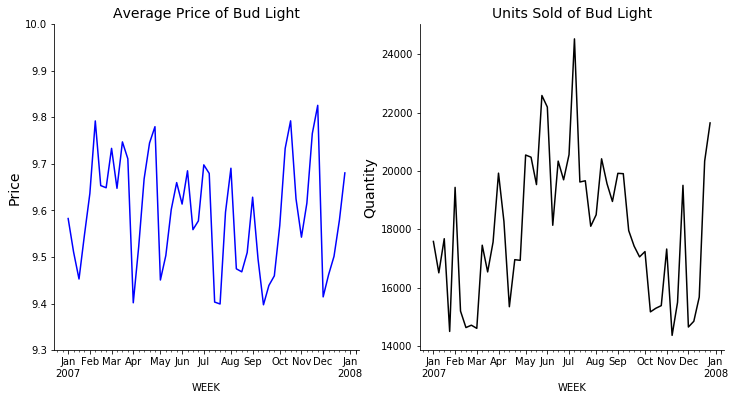

In [207]:
freq = "W"

fig, ax = plt.subplots(1,2, figsize = (12,6))

#fig.tight_layout(h_pad=10)

sales_budlight.resample(freq).mean().price.plot(ax = ax[0], color = 'b')

ax[0].set_title("Average Price of Bud Light", fontsize = 14)

ax[0].set_ylabel("Price", fontsize = 14,)

ax[0].spines["right"].set_visible(False) # This removes the ``spines'', just the right and top
ax[0].spines["top"].set_visible(False) # ones...

ax[0].set_ylim([9.30,10.0])

##################################################################################

sales_budlight.resample(freq).sum().UNITS.plot(ax = ax[1], color = 'k')

ax[1].set_title("Units Sold of Bud Light", fontsize = 14)

ax[1].set_ylabel("Quantity", fontsize = 14,)

ax[1].spines["right"].set_visible(False) # This removes the ``spines'', just the right and top
ax[1].spines["top"].set_visible(False) # ones...

plt.show()

### Adding in Market Dimension

Then in the file there is a story level variable. This will compute total says (of the product?) with some information about the store, e.g. when it opened, closed, and market name. Again, this is a fixed with file. 

In [196]:
file_path = "F://Academic Dataset External//Year7//External//beer"
file = "//Delivery_Stores"
file = file_path+file

stores = pd.read_fwf(file)

In [197]:
display(stores.shape)

display(stores.head())

display(stores.Market_Name.unique())

(2139, 7)

,IRI_KEY,OU,EST_ACV,Market_Name,Open,Clsd,MskdName
0,200171,GR,25.883990,MILWAUKEE,522,9998,Chain87
1,200197,GR,11.405000,PEORIA/SPRINGFLD.,903,9998,Chain50
2,200272,GR,12.730000,LOS ANGELES,873,9998,Chain115
3,200287,GR,7.268997,SAN FRANCISCO,795,1443,Chain83
4,200297,GR,21.965990,"PORTLAND,OR",999,9998,Chain69


array(['MILWAUKEE', 'PEORIA/SPRINGFLD.', 'LOS ANGELES', 'SAN FRANCISCO',
       'PORTLAND,OR', 'SAN DIEGO', 'SOUTH CAROLINA', 'HARTFORD',
       'NEW YORK', 'WEST TEX/NEW MEX', 'OKLAHOMA CITY', 'BOSTON',
       'HOUSTON', 'GREEN BAY', 'CHARLOTTE', 'TULSA,OK', 'NEW ORLEANS, LA',
       'SALT LAKE CITY', 'OMAHA', 'RICHMOND/NORFOLK', 'ROANOKE',
       'RALEIGH/DURHAM', 'PHILADELPHIA', 'SYRACUSE', 'SPOKANE', 'ATLANTA',
       'MISSISSIPPI', 'NEW ENGLAND', 'KNOXVILLE', 'PITTSFIELD',
       'WASHINGTON, DC', 'CHICAGO', 'BUFFALO/ROCHESTER',
       'HARRISBURG/SCRANT', 'SEATTLE/TACOMA', 'GRAND RAPIDS',
       'MINNEAPOLIS/ST. P', 'SACRAMENTO', 'TOLEDO', 'DALLAS, TX',
       'EAU CLAIRE', 'ST. LOUIS', 'BIRMINGHAM/MONTG.', 'INDIANAPOLIS',
       'PROVIDENCE,RI', 'PHOENIX, AZ', 'KANSAS CITY', 'DETROIT',
       'CLEVELAND', 'DES MOINES'], dtype=object)

In [198]:
#display(stores[stores.Market_Name == "CHICAGO"].head(10))

grouped = stores.groupby("Market_Name")

display(grouped.IRI_KEY.count())

Market_Name
ATLANTA               44
BIRMINGHAM/MONTG.     39
BOSTON                66
BUFFALO/ROCHESTER     36
CHARLOTTE             39
CHICAGO               97
CLEVELAND             16
DALLAS, TX            72
DES MOINES            11
DETROIT               51
EAU CLAIRE             8
GRAND RAPIDS          21
GREEN BAY             10
HARRISBURG/SCRANT     49
HARTFORD              43
HOUSTON               53
INDIANAPOLIS          26
KANSAS CITY           29
KNOXVILLE             22
LOS ANGELES          148
MILWAUKEE             37
MINNEAPOLIS/ST. P     30
MISSISSIPPI           22
NEW ENGLAND           51
NEW ORLEANS, LA       32
NEW YORK             179
OKLAHOMA CITY         11
OMAHA                 15
PEORIA/SPRINGFLD.     26
PHILADELPHIA          75
PHOENIX, AZ           62
PITTSFIELD            15
PORTLAND,OR           39
PROVIDENCE,RI         20
RALEIGH/DURHAM        52
RICHMOND/NORFOLK      42
ROANOKE               36
SACRAMENTO            39
SALT LAKE CITY        17
SAN DIEGO    

In [199]:
sales_market_bud = pd.merge(sales_budlight,stores, how = "inner", left_on = "IRI_KEY", right_on = "IRI_KEY", indicator = True)

In [200]:
sales_market_bud.head(10)

sales_market_bud.set_index(pd.DatetimeIndex(sales_market_bud['WEEK']), inplace = True)

sales_market_bud.head()

sales_market_bud.index

DatetimeIndex(['2007-01-07', '2007-01-14', '2007-01-21', '2007-01-28',
               '2007-02-04', '2007-02-11', '2007-02-18', '2007-02-25',
               '2007-03-04', '2007-03-11',
               ...
               '2007-10-28', '2007-11-04', '2007-11-11', '2007-11-18',
               '2007-11-25', '2007-12-02', '2007-12-09', '2007-12-16',
               '2007-12-23', '2007-12-30'],
              dtype='datetime64[ns]', name='WEEK', length=54197, freq=None)

In [201]:
sales_market_bud.head()

,IRI_KEY,WEEK,SY,GE,VEND,ITEM,UNITS,DOLLARS,F,D,PR,price,OU,EST_ACV,Market_Name,Open,Clsd,MskdName,_merge
WEEK,,,,,,,,,,,,,,,,,,,
2007-01-07,234212,2007-01-07,0,1,18200,769,29,246.51,NONE,1,1,8.500345,GR,37.67798,CHICAGO,435,9998,Chain46,both
2007-01-14,234212,2007-01-14,0,1,18200,769,27,229.83,B,1,1,8.512222,GR,37.67798,CHICAGO,435,9998,Chain46,both
2007-01-21,234212,2007-01-21,0,1,18200,769,33,281.67,NONE,1,0,8.535455,GR,37.67798,CHICAGO,435,9998,Chain46,both
2007-01-28,234212,2007-01-28,0,1,18200,769,33,281.37,B,1,0,8.526364,GR,37.67798,CHICAGO,435,9998,Chain46,both
2007-02-04,234212,2007-02-04,0,1,18200,769,56,476.34,NONE,1,1,8.506071,GR,37.67798,CHICAGO,435,9998,Chain46,both


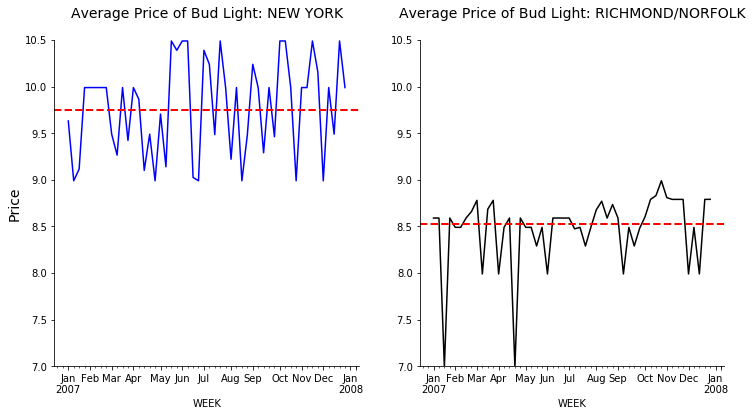

In [216]:
freq = "W"

mk_one_name = "NEW YORK"
mk_two_name = "RICHMOND/NORFOLK"

############################

fig, ax = plt.subplots(1,2, figsize = (12,6))

#fig.tight_layout(h_pad=10)

market_one = sales_market_bud[sales_market_bud.Market_Name == mk_one_name]

market_one.resample(freq).median().price.plot(ax = ax[0], color = 'b')

ax[0].set_title("Average Price of Bud Light: " + mk_one_name + "\n", fontsize = 14)

ax[0].set_ylabel("Price", fontsize = 14,)

ax[0].spines["right"].set_visible(False) # This removes the ``spines'', just the right and top
ax[0].spines["top"].set_visible(False) # ones...

avg = market_one.resample(freq).mean().price.mean()

ax[0].axhline(y=avg, color='r', label='Average', linestyle='--', linewidth=2)

ax[0].set_ylim([7.0,10.5])

##################################################################################

market_two = sales_market_bud[sales_market_bud.Market_Name == mk_two_name]

market_two.resample(freq).median().price.plot(ax = ax[1], color = 'k')

ax[1].set_title("Average Price of Bud Light: " + mk_two_name + "\n", fontsize = 14)

ax[1].set_ylabel("\n\n\n\n", fontsize = 14,)

ax[1].spines["right"].set_visible(False) # This removes the ``spines'', just the right and top
ax[1].spines["top"].set_visible(False) # ones...

avg = market_two.resample(freq).mean().price.mean()

ax[1].axhline(y=avg, color='r', label='Average', linestyle='--', linewidth=2)

ax[1].set_ylim([7.0,10.5])

plt.show()

In [220]:
grouped = sales_market_bud.groupby("Market_Name")

grouped.price.mean().sort_values()

Market_Name
CHICAGO               8.136440
RICHMOND/NORFOLK      8.523616
PEORIA/SPRINGFLD.     8.540275
BUFFALO/ROCHESTER     8.600331
ROANOKE               8.634385
INDIANAPOLIS          8.686727
PHILADELPHIA          8.768585
MILWAUKEE             8.789764
CLEVELAND             8.792064
EAU CLAIRE            8.848773
CHARLOTTE             8.858651
RALEIGH/DURHAM        8.864661
TOLEDO                8.876727
GREEN BAY             8.889900
SOUTH CAROLINA        9.109745
OKLAHOMA CITY         9.177184
GRAND RAPIDS          9.200853
MISSISSIPPI           9.244224
SYRACUSE              9.333190
WASHINGTON, DC        9.339612
BIRMINGHAM/MONTG.     9.373053
NEW ORLEANS, LA       9.400187
KNOXVILLE             9.417912
KANSAS CITY           9.433222
NEW ENGLAND           9.442592
PORTLAND,OR           9.574996
ATLANTA               9.592859
DES MOINES            9.665827
DETROIT               9.676606
SEATTLE/TACOMA        9.686563
HOUSTON               9.724848
SPOKANE               9.749